# Constructing the projection matrix $A$

$$
\mathrm{PSF}_{k,\lambda}(x,y) =
    G\left({{x-x_0} \over \sigma_x}\right)
    G\left({{y-y_0} \over \sigma_y}\right)
    \sum_{i,j}
    c_{ij}
    H_i\left({{x-x_0} \over \sigma_x}\right)
    H_j\left({{y-y_0} \over \sigma_y}\right)
$$

Where $G(z) = e^{-0.5 z^2}/\sqrt{2\pi}$ and $H_i(z)$ are the "probabalist's" Hermite polynomials.  These are often listed as $He_i(z)$ (*e.g.* in Wikipedia and numpy code) to differentiate them from the "physicist's"
Hermite polynomials but here will will simply use $H_i(z)$.

**TODO**:
  * Add PSF tails
  * Document more, cleanup code and cryptic variable/function names
  * Put this all together with divide-and-conquer extractions

In [1]:
import os, sys, time
import numpy as np
from astropy.table import Table
import numba
import scipy.special

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Evaluating the Legendre polynomials for the PSF parameters

The PSF parameters $p$ ($x_0$, $y_0$, $\sigma_x$, $\sigma_y$, $c_{ij}$ etc.)
are stored as the coefficients $a$ of Legendre polynomials vs. wavelength for each spectrum $k$:

$$
p_k(\lambda) = \sum_i a_{ki} L_i(w)
$$

where the wavelength $\lambda$ is mapped to the domain $w \in [-1,1]$ with

$$
w = 2 {{\lambda - \lambda_{min}} \over {\lambda_{max} - \lambda_{min}}} - 1
$$

First we'll build a cache of all parameters evaluated at all wavelengths for all spectra.
Since this will involve evaluating Legendre polynomials at the same wavelengths for many
different sets of coefficients, we can do this efficiently by constructing the
Vandermonde Matrix and then taking the dot product with all coefficients at once.

In [2]:
#- Read the PSF parameters from a PSF file without using specter
psfdata = Table.read('psf.fits')

In [3]:
psfdata.colnames

['PARAM', 'WAVEMIN', 'WAVEMAX', 'COEFF']

The wavelengths at which we evaluate the PSFs is arbitrary as long as they are within
the `WAVEMIN` and `WAVEMAX` specified.

**Note**: in principle the format species a `WAVEMIN` and `WAVEMAX` for each parameter.
In practice those are always the same but we'll check anyway.

In [4]:
wavelengths = np.arange(psfdata['WAVEMIN'][0], psfdata['WAVEMAX'][0], 0.8)
if np.any(psfdata['WAVEMIN'] != psfdata['WAVEMIN'][0]):
    raise RuntimeError('different values of WAVEMIN are not supported')
if np.any(psfdata['WAVEMAX'] != psfdata['WAVEMAX'][0]):
    raise RuntimeError('different values of WAVEMAX are not supported')

In [5]:
def evalcoeffs(wavelengths, psfdata):
    '''
    wavelengths: 1D array of wavelengths to evaluate all coefficients for all wavelengths of all spectra
    psfdata: Table of parameter data ready from a GaussHermite format PSF file
    
    Returns a dictionary params[paramname] = value[nspec, nwave]
    
    The Gauss Hermite coefficients are treated differently:
    
        params['GH'] = value[i,j,nspec,nwave]
        
    The dictionary also contains scalars with the recommended spot size HSIZEX, HSIZEY
    and Gauss-Hermite degrees GHDEGX, GHDEGY (which is also derivable from the dimensions
    of params['GH'])
    '''
    wavemin, wavemax = psfdata['WAVEMIN'][0], psfdata['WAVEMAX'][0]
    wx = (wavelengths - wavemin) * (2.0 / (wavemax - wavemin)) - 1.0
    L = np.polynomial.legendre.legvander(wx, psfdata.meta['LEGDEG'])
    
    p = dict(WAVE=wavelengths)
    nparam, nspec, ndeg = psfdata['COEFF'].shape
    nwave = L.shape[0]
    p['GH'] = np.zeros((psfdata.meta['GHDEGX']+1, psfdata.meta['GHDEGY']+1, nspec, nwave))
    for name, coeff in zip(psfdata['PARAM'], psfdata['COEFF']):
        name = name.strip()
        if name.startswith('GH-'):
            i, j = map(int, name.split('-')[1:3])
            p['GH'][i,j] = L.dot(coeff.T).T
        else:
            p[name] = L.dot(coeff.T).T
    
    #- Include some additional keywords that we'll need
    for key in ['HSIZEX', 'HSIZEY', 'GHDEGX', 'GHDEGY']:
        p[key] = psfdata.meta[key]
    
    return p

%time p = evalcoeffs(wavelengths, psfdata)

CPU times: user 1.39 s, sys: 260 ms, total: 1.65 s
Wall time: 1.66 s


In [6]:
p.keys()

dict_keys(['WAVE', 'GH', 'X', 'Y', 'GHSIGX', 'GHSIGY', 'TAILAMP', 'TAILCORE', 'TAILXSCA', 'TAILYSCA', 'TAILINDE', 'CONT', 'HSIZEX', 'HSIZEY', 'GHDEGX', 'GHDEGY'])

Text(0,0.5,'CCD y')

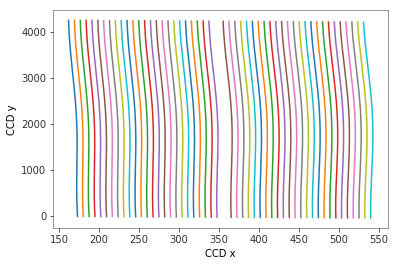

In [7]:
for i in range(50):
    plot(p['X'][i], p['Y'][i])
xlabel('CCD x'); ylabel('CCD y')

In [8]:
psfdata.meta

OrderedDict([('comments',
              ['------------------------------------------------------------------------',
               'PSF generated by specex, https://github.com/julienguy/specex',
               'PSF fit date 2015-01-12',
               '-',
               'Each row of the table contains the data vector of one PSF parameter',
               'The size of the vector is ((FIBERMAX-FIBERMIN+1)*(LEGDEG+1))',
               'Description of  the NPARAMS parameters :',
               'X        : CCD column coordinate (as a function of fiber and wavelength)',
               'Y        : CCD row coordinate (as a function of fiber and wavelength)',
               '         (X,Y)=(0,0) means that PSF is centered on center of first pixel',
               'GHSIGX   : Sigma of first Gaussian along CCD columns for PSF core',
               'GHSIGY   : Sigma of first Gaussian along CCD rows for PSF core',
               'GH-i-j   : Hermite pol. coefficents, i along columns, j along rows,

## 2D Pixelated Gauss-Hermite Polynomials

To create the projection matrix $A$, we will need to integrate the PSF over CCD pixels.  Recall that the PSF is modeled as:

$$
\mathrm{PSF}_{k,\lambda}(x,y) =
    G\left({{x-x_0} \over \sigma_x}\right)
    G\left({{y-y_0} \over \sigma_y}\right)
    \sum_{i,j}
    c_{ij}
    He_i\left({{x-x_0} \over \sigma_x}\right)
    He_j\left({{y-y_0} \over \sigma_y}\right)
$$

We will use the relation

$$
\int{ He_k(x) e^{-0.5 x^2} dx} = -He_{k-1}(x) e^{-0.5 x^2} + const
$$

and like the PSF coefficients, we will pre-calculate and cache the evaluations so that they
can be done in a single vectorized call instead of many individual evaluations.
We will do these evaluations for all wavelengths of a single spectrum at a time.

In [9]:
from numpy.polynomial import hermite_e as He

def calc_pgh(ispec, wavelengths, psfparams):
    '''
    Calculate the pixelated Gauss Hermite for all wavelengths of a single spectrum
    
    ispec : integer spectrum number
    wavelengths : array of wavelengths to evaluate
    psfparams : dictionary of PSF parameters returned by evalcoeffs
    
    returns pGHx, pGHy
    
    where pGHx[ghdeg+1, nwave, nbinsx] contains the pixel-integrated Gauss-Hermite polynomial
    for all degrees at all wavelengths across nbinsx bins spaning the PSF spot, and similarly
    for pGHy.  The core PSF will then be evaluated as
    
    PSFcore = sum_ij c_ij outer(pGHy[j], pGHx[i])
    '''
    
    #- shorthand
    p = psfparams
    
    #- spot size (ny,nx)
    nx = p['HSIZEX']
    ny = p['HSIZEY']
    nwave = len(wavelengths)
    # print('Spot size (ny,nx) = {},{}'.format(ny, nx))
    # print('nwave = {}'.format(nwave))

    #- x and y edges of bins that span the center of the PSF spot
    xedges = np.repeat(np.arange(nx+1) - nx//2, nwave).reshape(nx+1, nwave)
    yedges = np.repeat(np.arange(ny+1) - ny//2, nwave).reshape(ny+1, nwave)
    
    #- Shift to be relative to the PSF center at 0 and normalize
    #- by the PSF sigma (GHSIGX, GHSIGY)
    xedges = ((xedges - p['X'][ispec]%1)/p['GHSIGX'][ispec])
    yedges = ((yedges - p['Y'][ispec]%1)/p['GHSIGY'][ispec])    
    # print('xedges.shape = {}'.format(xedges.shape))
    # print('yedges.shape = {}'.format(yedges.shape))

    #- Degree of the Gauss-Hermite polynomials
    ghdegx = p['GHDEGX']
    ghdegy = p['GHDEGY']

    #- Evaluate the Hermite polynomials at the pixel edges
    HVx = He.hermevander(xedges, ghdegx).T
    HVy = He.hermevander(yedges, ghdegy).T
    # print('HVx.shape = {}'.format(HVx.shape))
    # print('HVy.shape = {}'.format(HVy.shape))

    #- Evaluate the Gaussians at the pixel edges
    Gx = np.exp(-0.5*xedges**2).T / np.sqrt(2. * np.pi)   # (nwave, nedges)
    Gy = np.exp(-0.5*yedges**2).T / np.sqrt(2. * np.pi)
    # print('Gx.shape = {}'.format(Gx.shape))
    # print('Gy.shape = {}'.format(Gy.shape))

    #- Combine into Gauss*Hermite
    GHx = HVx * Gx
    GHy = HVy * Gy

    #- Integrate over the pixels using the relationship
    #  Integral{ H_k(x) exp(-0.5 x^2) dx} = -H_{k-1}(x) exp(-0.5 x^2) + const

    pGHx = np.zeros((ghdegx+1, nwave, nx))
    pGHy = np.zeros((ghdegy+1, nwave, ny))
    pGHx[0] = 0.5 * np.diff(scipy.special.erf(xedges/np.sqrt(2.)).T)
    pGHy[0] = 0.5 * np.diff(scipy.special.erf(yedges/np.sqrt(2.)).T)
    pGHx[1:] = GHx[:ghdegx,:,0:nx] - GHx[:ghdegx,:,1:nx+1]
    pGHy[1:] = GHy[:ghdegy,:,0:ny] - GHy[:ghdegy,:,1:ny+1]
    
    return pGHx, pGHy

pGHx, pGHy = calc_pgh(0, wavelengths, p)

In [10]:
%timeit pGHx, pGHy = calc_pgh(0, wavelengths, p)

8.16 ms ± 46.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
pGHx.shape

(9, 2802, 14)

### Evaluate multiple spots at once

We'll now use those cached pixelated Gauss-Hermite functions to evaluate the
spots at multiple wavelengths

In [12]:
@numba.jit(nopython=True)
def multispot(pGHx, pGHy, ghc):
    nx = pGHx.shape[-1]
    ny = pGHy.shape[-1]
    nwave = pGHx.shape[1]
    spots = np.zeros((nwave, ny, nx))

    tmpspot = np.zeros((ny,nx))
    for iwave in range(nwave):
        for i in range(pGHx.shape[0]):
            px = pGHx[i,iwave]
            for j in range(0, pGHy.shape[0]):
                py = pGHy[j,iwave]
                c = ghc[i,j,iwave]
                #- c * outer(py, px)
                for iy in range(len(py)):
                    for ix in range(len(px)):
                        spots[iwave, iy, ix] += c * py[iy] * px[ix]
    
    return spots

ispec = 0
mspots = multispot(pGHx, pGHy, p['GH'][:,:,ispec,:])

In [13]:
%timeit mspots = multispot(pGHx, pGHy, p['GH'][:,:,ispec,:])

27.5 ms ± 252 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Now put it all together to evaluate the spots for 50 spectra at all wavelengths,
which will take ~2 seconds.  Production code could parallelize this to evaluate
all spots for all wavelengths of all spectra simultaneously, or work in batches
like this to not blow memory.

In [14]:
t0 = time.time()
nspec = 50
nwave = len(wavelengths)
nx = p['HSIZEX']
ny = p['HSIZEY']
spots = np.zeros((nspec, nwave, ny, nx))
for ispec in range(nspec):
    pGHx, pGHy = calc_pgh(ispec, wavelengths, p)
    spots[ispec] = multispot(pGHx, pGHy, p['GH'][:,:,ispec,:])

dt = time.time() - t0
print('{:.2f} sec to calculate spots for {} spectra x {} wavelengths'.format(dt, nspec, nwave))

1.88 sec to calculate spots for 50 spectra x 2802 wavelengths


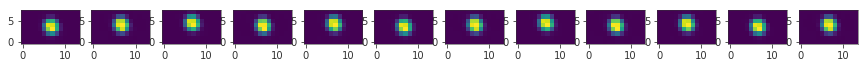

In [15]:
figure(figsize=(15,5))
for i in range(12):
    subplot(1,12,i+1)
    imshow(spots[0, i])

## Constructing $A$

Now let's use these spots to construct the matrix $A$ that projects fluxes $f$ onto pixels $p = Af$.
for this we'll need to know the spots (already calculated and cached) as also the corners of
where those spots go on the full 2D image.

In [16]:
xc = np.floor(p['X'] - p['HSIZEX']//2).astype(int)
yc = np.floor(p['Y'] - p['HSIZEY']//2).astype(int)
corners = (xc, yc)

@numba.jit
def projection_matrix(ispec, nspec, iwave, nwave, spots, corners):
    '''
    TODO: document
    '''
    ny, nx = spots.shape[2:4]
    xc, yc = corners
    xmin = np.min(xc[ispec:ispec+nspec, iwave:iwave+nwave])
    xmax = np.max(xc[ispec:ispec+nspec, iwave:iwave+nwave]) + nx
    ymin = np.min(yc[ispec:ispec+nspec, iwave:iwave+nwave])
    ymax = np.max(yc[ispec:ispec+nspec, iwave:iwave+nwave]) + ny
    # print('ymin, ymax = {}, {}'.format(ymin, ymax))
    A = np.zeros((ymax-ymin,xmax-xmin,nspec,nwave))
    # print('A.shape = {}'.format(A.shape))
    for i in range(nspec):
        for j in range(nwave):
            ixc = xc[ispec+i, iwave+j] - xmin
            iyc = yc[ispec+i, iwave+j] - ymin
            A[iyc:iyc+ny, ixc:ixc+nx, i, j] = spots[ispec+i,iwave+j]
    
    return A, ymin, xmin

A, ymin, xmin = projection_matrix(1, 5, 0, 20, spots, corners)
print(A.shape, ymin, xmin)

(37, 43, 5, 20) -18 173


In [22]:
%timeit A, ymin, xmin = projection_matrix(0, 5, 0, 70, spots, corners)

638 µs ± 8.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


CPU times: user 11.5 ms, sys: 11.9 ms, total: 23.5 ms
Wall time: 23.9 ms


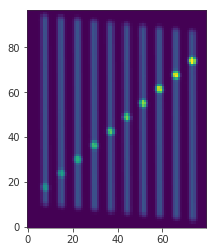

In [18]:
nspec = 10
nwave = 60
influx = np.ones((nspec, nwave))
for i in range(nspec):
    influx[i, 5*(i+1)] += 2 + 0.5*(i+1)

# influx[0, 9] = 2

%time A, ymin, xmin = projection_matrix(0, nspec, 5, nwave, spots, corners)
nypix, nxpix = A.shape[0:2]
Ax = A.reshape(nypix*nxpix, nspec*nwave)
image = Ax.dot(influx.ravel()).reshape(nypix, nxpix)
imshow(image)

### Compare to Specter GaussHermite psf.projection_matrix() timing

A full set of extractions involves approximately 5600 projection matrix evaluations.
Including the time to build the cache for all 500 spectra, this would take
2s + 20s + 5600 &times; 700 &mu;s = 26 seconds on a single core, which almost seems too
good to be true.

For comparison, the specter PSF evaluations take ~90ms each = 500 seconds.

The code in this notebook doesn't yet include the evaluation of the tails of the PSFs,
but there are still huge wins from doing larger vectorized operations, using
`legvander` and `hermevander`, and simplifiying the bookkeeping to reduce the overhead.



In [19]:
import specter.psf
psf = specter.psf.load_psf('psf.fits')

In [20]:
specrange = 0, nspec
ww = wavelengths[0:nwave]
xyrange = psf.xyrange(specrange, ww)
A = psf.projection_matrix(specrange, ww, xyrange)

In [21]:
%timeit A = psf.projection_matrix(specrange, ww, xyrange)

96.8 ms ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
